In [ ]:
import numpy as np

def softmax(h):
    phat = np.exp(h)/((np.sum(np.exp(h),axis = 1)).reshape(len(h),1))
    return phat

def sigmoid(h):
    return (1/(1 + np.exp(-h)))

def crossEntropy(p,y):
    if y.shape[1] <= 1:
        return -np.sum(np.multiply(y,np.log(p))+np.multiply((1-y),np.log(1-p)))/len(p)
    else:
        return -np.sum(np.multiply(y,np.log(p)))/len(p)

def sumOfSquares(yhat, y):
    if y.shape[1] <= 1:
        return np.sum((y-yhat).T@(y-yhat))/len(yhat)
    else:
        return np.sum(np.trace((y-yhat).T.dot(y-yhat)))/len(yhat)

def derivTanh(z):
    return(1-z**2)

def RELU(x):
    return x*(x>0)

def derivRELU(x):
    return x>0

In [185]:
class NeuralNetwork:
    
    def __init__(self, X, Y, nodes=[6,6,6], activation='tanh', customactivation=None, customdractivation=None, task='classification', customtask=None, customcost=None): 
        self.indims = np.array(X).shape[1]
        self.outdims = np.array(Y).shape[1]
        self.nodes = nodes
        self.nodes.append(self.outdims)
        self.layers = len(self.nodes)
        self.X = np.array(X)
        self.Y = np.array(Y)
        #for the activation function, tanh and RELU can be chosen by default
        if activation == 'tanh':
            self.activate = np.tanh
            self.dr_activate = derivTanh
        elif activation == 'RELU':
            self.activate = RELU
            self.dr_activate = derivRELU
        #A custom activation can be used by passing a list of length 2 containing a function and its derivative
        elif activation == 'custom':
            self.activate = customactivation
            self.dr_activate = customdractivation
        else:
            print("Invalid activation input")
        #Right now it can only take classification and regression, but it can accept custom inputs.
        if task == 'classification':
            if self.Y.shape[1] == 1:
                self.outputFunc = sigmoid
                self.costFunc = crossEntropy
            elif self.Y.shape[1] > 1:
                self.outputFunc = softmax
                self.costFunc = crossEntropy
            else:
                print("Invalid dimensions")
        elif task == 'regression':
            self.outputFunc = lambda x:x*1
            self.costFunc = sumOfSquares
        elif task == 'custom':
            self.outputFunc = customtask
            self.costFunc = customcost
        else:
            print("Invalid task input")
                
    def initializeWeights(self):
        self.W = {}
        self.B = {}
        self.Mw = {}
        self.Mb = {}
        self.G = {}
        self.LR = {}
        self.W['0'] = np.random.randn(self.indims, self.nodes[0])
        self.G['W0'] = np.ones_like(self.W['0'])
        self.B['0'] = np.random.randn(1, self.nodes[0])
        self.G['B0'] = np.ones_like(self.B['0'])
        self.Mw['0'] = np.zeros((self.indims, self.nodes[0]))
        self.Mb['0'] = np.zeros((1, self.nodes[0]))
        for i in range(1, self.layers):
            self.W[str(i)] = np.random.randn(self.nodes[i-1], self.nodes[i])
            self.G['W'+str(i)] = np.ones_like(self.W[str(i)])
            self.B[str(i)] = np.random.randn(1, self.nodes[i])
            self.G['B'+str(i)] = np.ones_like(self.B[str(i)])
            self.Mw[str(i)] = np.zeros((self.nodes[i-1], self.nodes[i]))
            self.Mb[str(i)] = np.zeros((1, self.nodes[i]))
            
    def initializeParams(self, LR):
        self.W = {}
        self.B = {}
        self.Mw = {}
        self.Mb = {}
        self.G = {}
        self.LR = {}
        self.W['0'] = np.random.randn(self.indims, self.nodes[0]) * np.sqrt(2/(self.indims+self.nodes[0]))
        self.G['W0'] = np.ones_like(self.W['0'])
        self.B['0'] = np.random.randn(1, self.nodes[0]) * np.sqrt(2/(self.indims+self.nodes[0]))
        self.G['B0'] = np.ones_like(self.B['0'])
        self.Mw['0'] = np.zeros((self.indims, self.nodes[0]))
        self.Mb['0'] = np.zeros((1, self.nodes[0]))        
        for i in range(1, self.layers):
            self.W[str(i)] = np.random.randn(self.nodes[i-1], self.nodes[i]) * np.sqrt(2/(self.nodes[i-1]+self.nodes[i]))
            self.G['W'+str(i)] = np.ones_like(self.W[str(i)])
            self.B[str(i)] = np.random.randn(1, self.nodes[i]) * np.sqrt(2/(self.nodes[i-1]+self.nodes[i]))
            self.G['B'+str(i)] = np.ones_like(self.B[str(i)])
            self.Mw[str(i)] = np.zeros((self.nodes[i-1], self.nodes[i]))
            self.Mb[str(i)] = np.zeros((1, self.nodes[i]))
        for i in range(0,self.layers):
            self.LR['W'+str(i)] = LR
            self.LR['B'+str(i)] = LR

    
    def split(self, X,Y, split=.8):
        data_index = np.array(range(0,len(X)))
        np.random.shuffle(data_index)
        sp_i = int(np.floor(len(X)*split))
        trn_i = data_index[0:sp_i]
        val_i = data_index[sp_i:]
        self.trn = np.take(X, trn_i, axis=0)
        self.ytrn = np.take(Y, trn_i, axis=0)
        self.val = np.take(X, val_i, axis=0)
        self.yval = np.take(Y, val_i, axis=0)
        
    def validate(self, X):
        self.A = {}
        self.Z = {}
        #self.setActivation()
        self.A['0'] = X@self.W['0']+self.B['0']
        self.Z['0'] = self.activate(self.A['0'])
        for z in range(1,self.layers-1):
            self.A[str(z)] = self.Z[str(z-1)]@self.W[str(z)]+self.B[str(z)]
            self.Z[str(z)] = self.activate(self.A[str(z)])
        self.A[str(self.layers-1)] = self.Z[str(self.layers-2)]@self.W[str(self.layers-1)]+self.B[str(self.layers-1)]
        self.yhat = self.outputFunc(self.A[str(self.layers-1)])
    
    def setDerivs(self, yhat, y):
        self.D = {}
        self.D[str(self.layers-1)] = (yhat-y)
        for d in range(2, self.layers+1):
            self.D[str(self.layers-d)] = (self.D[str(self.layers-d+1)]@self.W[str(self.layers-d+1)].T)*self.dr_activate(self.Z[str(self.layers-d)])

    def setGradients(self, X):
        self.gradW = {}
        self.gradB = {}
        self.gradW['0'] =  X.T@self.D['0']
        self.gradB['0'] =  np.sum(self.D['0'])
        for g in range(1,self.layers):
            self.gradW[str(g)] =  self.Z[str(g-1)].T@self.D[str(g)]
            self.gradB[str(g)] =  np.sum(self.D[str(g)], axis=0)
    
    def adaGrad(self):
        for i in range(0, self.layers):
            self.G['W'+str(i)] = .9*self.G['W'+str(i)] + (1-.9)*self.gradW[str(i)]**2
            self.G['B'+str(i)] = .9*self.G['B'+str(i)] + (1-.9)*self.gradB[str(i)]**2
            
    def lrUpdate(self,LR, update=False):
        if update == False:    
            for i in range(0,self.layers):
                self.LR['W'+str(i)] = LR
                self.LR['B'+str(i)] = LR       
        if update == True:
            self.adaGrad()
            for i in range(0,self.layers):
                self.LR['W'+str(i)] = LR / np.sqrt(self.G['W'+str(i)]+1e-10)
                self.LR['B'+str(i)] = LR / np.sqrt(self.G['B'+str(i)]+1e-10)
            
    def nstvMomentumUpdate(self, X, cof=.9):
        for m in range(0,self.layers):
            self.W[str(m)] += cof*self.Mw[str(m)]
            self.B[str(m)] += cof*self.Mb[str(m)]
        self.validate(X)
        self.setDerivs(self.yhat,self.ytrn)
        self.setGradients(X)
        for m in range(0,self.layers):
            self.W[str(m)] -= cof*self.Mw[str(m)]
            self.B[str(m)] -= cof*self.Mb[str(m)]        
        
    def momentumUpdate(self, cof=.9):
        for w in range(0, self.layers):
            self.Mw[str(w)] = cof*self.Mw[str(w)] - self.LR['W'+str(w)] * self.gradW[str(w)] 
            self.Mb[str(w)] = cof*self.Mb[str(w)] - self.LR['B'+str(w)] * self.gradB[str(w)]
            
    def weightUpdate(self):
        for w in range(0, self.layers):
            self.W[str(w)] += self.Mw[str(w)]
            self.B[str(w)] += self.Mb[str(w)]
    
    def everyday(self, X, Y):
        rng_state = numpy.random.get_state()
        numpy.random.shuffle(X)
        numpy.random.set_state(rng_state)
        numpy.random.shuffle(Y)
            
            
    
    #def setActivation(self, *args):
    
    def train(self, LR=1e-5, LRupdate=False, epochs=1000, vocal=False, split=.8, reinit=True, acceleration=None,
              momentum=0, decay=None, decayterms=[.9,900]):
        self.split(self.X, self.Y, split=split)
        self.Errors = []
        err_best = np.inf
        if reinit == True:
            self.initializeParams(LR=LR) 
        for ep in range(epochs):
            self.validate(self.trn)
            self.setDerivs(self.yhat, self.ytrn)
            self.setGradients(self.trn)
            self.lrUpdate(LR=LR, update=LRupdate)
            if acceleration == 'nesterov':
                self.nstvMomentumUpdate(self.trn, cof=momentum)
                self.momentumUpdate(cof=momentum)
            elif acceleration == 'momentum':
                self.momentumUpdate(cof=momentum)
            else:
                self.momentumUpdate(cof=0)
            self.weightUpdate()
            if decay == 'scheduled':
                self.LR = LR*decayterms[0]**(epochs/decayterms[1])
            elif decay == 'inverse':
                self.LR = LR / (decayterms[0]*epochs+1)
            elif decay == 'exponential':
                self.LR = LR*np.exp(-decayterms[0]*epochs)
            self.validate(self.val)
            err = self.costFunc(self.yhat,self.yval)
            self.Errors.append(err)
            if vocal == True:
                print('Epoch: {} / Error: {}'.format(ep, err))
            if np.isnan(err) | np.isinf(err):
                self.initializeParams()
                break
            if err < err_best:
                self.Wbest = self.W
                self.Bbest = self.B
                err_best = err
    
    
    def batchTrain(self, LR=1e-6, epochs=1000, vocal=False, reinit=True, split=.8, scaleweights=True, 
                   steps=1, momentum=0):
        self.LR = LR
        self.everyday(self.X, self.Y)
        self.split(self.X, self.Y, split=split)
        self.Errors = []
        if reinit == True:
            self.initializeWeightsScaled()
        for ep in range(epochs):
            for a in range(0,X.shape[0],steps):
                self.validate(X[a:steps+a,:])
                self.setDerivs(self.yhat, Y[a:steps+a,:])
                self.weightUpdate(X[a:steps+a,:], cof=momentum)
            self.validate(X)
            err = self.costFunc(self.yhat,Y)
            self.Errors.append(err)
            if vocal == True:
                print('Epoch: {} / Error: {}'.format(ep, err))
                                     
        
    def predict(self, test):
        self.Z = {}
        self.Z['0'] = self.activate(test@self.Wbest['0']+self.Bbest['0'])
        for i in range(1,self.layers-1):
            self.Z[str(i)] = self.activate(self.Z[str(i-1)]@self.Wbest[str(i)]+self.Bbest[str(i)])
        self.predictions=self.outputFunc(self.Z[str(self.layers-2)]@self.Wbest[str(self.layers-1)]+self.Bbest[str(self.layers-1)])


In [114]:
import matplotlib.pyplot as plt
#Min-max scaling
def normalizeMM(x,xtrn):
    newx = ((x - xtrn.min(0))/(xtrn.max(0)-xtrn.min(0)))
    return newx
    
def radius(x,r1,r2):
    delete = []
    for i in range(np.size(x,0)):
        if (np.sqrt(x[i,0]**2 + x[i,1]**2) < r1) | (r2 < np.sqrt(x[i,0]**2 + x[i,1]**2)):
            delete.append(i)
    xnew = np.delete(x, delete, 0)
    return xnew

def oneHotEncode(x):
    x = np.array(x)
    unique = np.unique(x)
    newx = np.zeros((x.shape[0], len(unique)))
    for i in range(x.shape[0]):
        for j in range(len(unique)):
            if x[i] == unique[j]:
                newx[i,j] = 1
    return newx

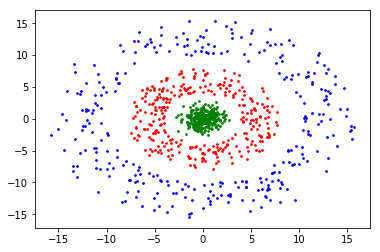

In [119]:
N = 300
x1 = np.random.randn(N,2)
x2 = np.random.randn(N*10,2)*4
x3 = np.random.randn(N*100,2)*8
x2 = radius(x2,4,8)
x3 = radius(x3,10,16)
np.random.shuffle(x2)
x2 = x2[0:300,]
np.random.shuffle(x3)
x3 = x3[0:300,]
labels1 = np.ones((N,1))
labels2 = np.zeros((N,1))
labels3 = np.repeat(2,N).reshape(N,1)
x1 = np.hstack((x1,labels1))
x2 = np.hstack((x2,labels2))
x3 = np.hstack((x3,labels3))
x_all = np.vstack((x1,x2,x3))
X = x_all[:,:-1]
Y = x_all[:,-1].reshape(len(x_all),1)
X = normalizeMM(X,X)
Y = oneHotEncode(Y)
plt.scatter(x1[:,0], x1[:,1], color="green", s=3)
plt.scatter(x2[:,0], x2[:,1], color="red", s=3)
plt.scatter(x3[:,0], x3[:,1], color="blue", s=3)
plt.show()

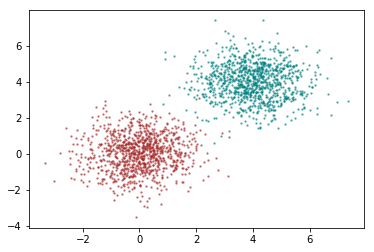

In [143]:
N = 1000
x0 = np.random.randn(N,2)+4
lab0 = np.zeros((N,1))
x1 = np.random.randn(N,2)
lab1 = np.ones((N,1))
X = np.vstack((x0,x1))
Y = np.vstack((lab0,lab1))
X = normalizeMM(X,X)
plt.scatter(x0[:,0],x0[:,1], s=2, alpha=.5, c="teal")
plt.scatter(x1[:,0],x1[:,1], s=2, alpha=.5, c="brown")
plt.show()

In [144]:
import time
def accuracy(p,y):
    if p.shape[1] == 1:
        yhat = np.rint(p)
    elif p.shape[1] > 1:
        yhat = (p == p.max(axis=1)[:,None]).astype(int)
    return np.mean(yhat == y)

In [183]:
NNr = NeuralNetwork(X,Y,nodes=[10,10], activation='RELU', task='custom', customtask=sigmoid, customcost=accuracy)

In [184]:
NNr.train(LRupdate=True, vocal=True, epochs=10000)

Epoch: 0 / Error: 0.545


ValueError: operands could not be broadcast together with shapes (2,10) (2,1600) 

In [135]:
NNr.LR['W0'].shape

(2, 10)